In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import itertools
import random
import pandas as pd
import matplotlib 

matplotlib.rcParams['figure.figsize'] = (16, 16)

##### Generate data with normal distribution

In [2]:
total_toss = 900
num_cluster = 3

In [3]:
params = [
            {"pi": 0.1, "mu": (10, 30), "covariance": [[0.88, 0.5], [0.5, 0.99]]},
            {"pi": 0.6, "mu": (30, 8), "covariance": [[0.6, 0.2], [0.2, 0.5]]},
            {"pi": 0.3, "mu": (12, 15), "covariance": [[1, 0], [0, 1]]}
        ]

In [4]:
def gen_data(num_cluster, total_toss):
    Z = [np.random.choice(num_cluster, 1, p=[params[i]['pi'] for i in range(num_cluster)])[0] for n_toss in range(total_toss)]
    data_dist = Counter(Z)
    data = {}
    for i in range(0, num_cluster):
        if data_dist[i] != 0: 
            data[i] = np.squeeze(np.random.multivariate_normal(params[i]["mu"], params[i]["covariance"], (1, data_dist[i])))
    return Z, data

In [5]:
actual_Z, data = gen_data(num_cluster, total_toss)

In [6]:
d = {k:v.tolist() for k, v in data.items()}
d_list = []
for k, v in d.items():
    for i in v:
        d_list.append([i[0], i[1], k])
dframe = pd.DataFrame(d_list, columns = ["X", "Y", "label"])

In [7]:
color = ['blue', 'green', 'cyan']

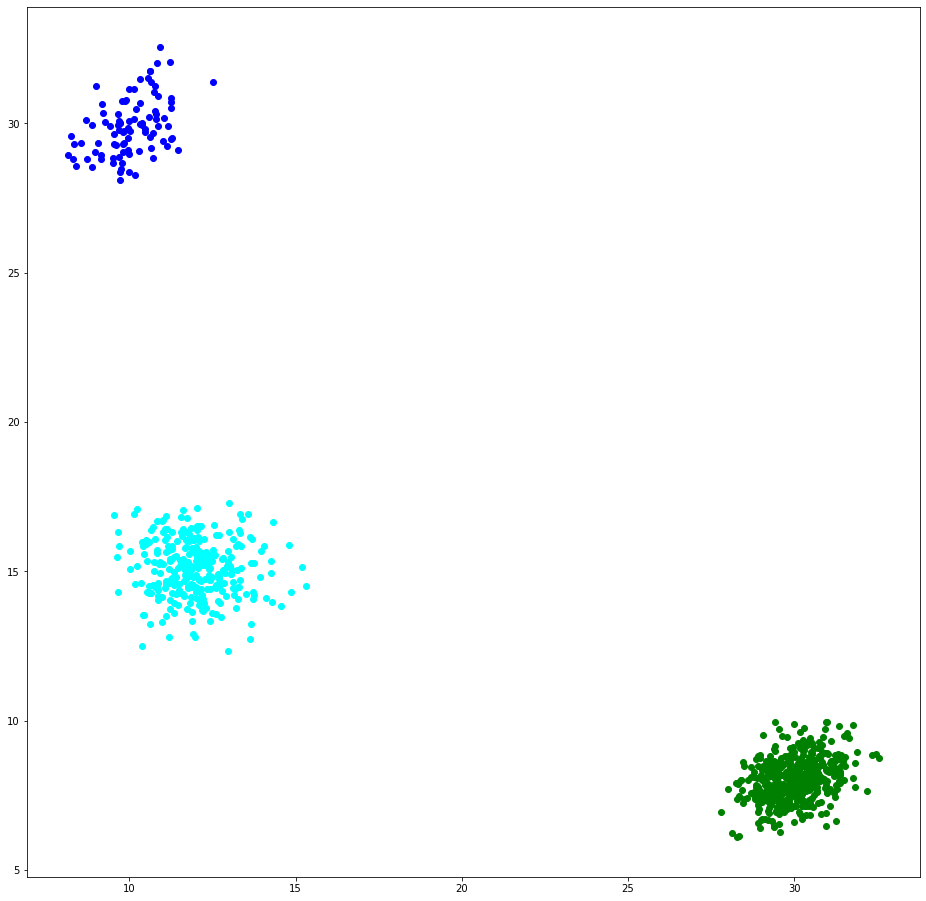

In [8]:
for k in range(num_cluster):
    ddata = dframe[dframe['label'] == k]
    plt.scatter(ddata['X'], ddata['Y'], c=color[k])

plt.show()

##### Generate covariance matrix 

In [9]:
def gen_cov_matrix(data):
    cov_matrix = {}
    # Covariance
    def cov(x, y):
        xbar, ybar = x.mean(), y.mean()
        return np.sum((x - xbar)*(y - ybar))/(len(x) - 1)

    # Covariance matrix
    def cov_mat(X):
        return np.array([[cov(X[0], X[0]), cov(X[0], X[1])], \
                         [cov(X[1], X[0]), cov(X[1], X[1])]])

    
    for i in range(len(data)):
        # Calculate covariance matrix 
        cov_matrix[i] = cov_mat(data[i].T) # (or with np.cov(X.T))
        
    return cov_matrix

##### Generate labels 

In [10]:
Z = [np.random.choice(num_cluster, 1, p=[1/num_cluster for i in range(num_cluster)])[0] for n_toss in range(total_toss)]

In [11]:
data_list = []
for key, value in data.items():
    data_list.append(value.tolist())

In [12]:
data_list = list(itertools.chain(*data_list))

In [13]:
c = list(zip(data_list, Z))

In [14]:
random.shuffle(c)

data_list, Z = zip(*c)

### Gaussian Prior

In [15]:
def gaussian_pdf(x_vector, mu_vector, covariance):
    # use case 
    # gaussian_pdf(np.array([3,2]), np.array([4,5]), np.array([[2,3], [3,2]]))
    D = len(x_vector)
    inv_covariance = np.linalg.inv(covariance)
    exp_term = np.exp(-0.5*np.dot(np.dot(np.transpose(x_vector-mu_vector),inv_covariance),(x_vector-mu_vector)))
    return (1/(2*np.pi)**D/2) * (1/np.abs(np.linalg.det(covariance))**0.5) * exp_term

##### UNKnown parameters 

In [16]:
# generate clusters by removing a data 
# gibbs sampling
def generate_cluster(X, data_i, Z, n_z):
    clusters = {}
    cluster_x = {}
    cluster_y = {}

    for k in range(0, n_z):
        clusters[k] = []
        cluster_x[k] = []
        cluster_y[k] = []
    
    for (x, z) in zip(X, Z):
        if (x == data_i).any():
            continue
        cluster_x[z].append(x[0])
        cluster_y[z].append(x[1])
    
    for k in range(len(cluster_x)):
        clusters[k] = np.vstack([cluster_x[k], cluster_y[k]]).T
        
    return clusters

In [17]:
# use inverse wishart distribution to estimate mean and covariance
def sample_mu_covariance(data, m=1, c =1, a =1, b =1):
    n = len(data[:, 0])
    mean = np.average(data, axis=0)
    covariance = 1/n * np.dot(np.transpose(data - mean), (data - mean))
    
    return mean, covariance

In [18]:
def calculate_prob(X, x, Z, count, A, N):
    clusters = generate_cluster(X, x, Z, num_cluster)
    covariance = {}
    mean = {}
    # calculate mean and variance as the parameters are assumed to be unknown
    for k in clusters:
        mean[k], covariance[k] = sample_mu_covariance(np.array(clusters[k]))

#         mu[k] = np.average(clusters[k], axis=0)
    mu = []
    for k, v in mean.items():
        mu.append(v)
    
    covariance = gen_cov_matrix(clusters)
    
    final_prob = []
    norm_final_prob = []

    for k in range(num_cluster):
        k_prob = gaussian_pdf(x, mu[k], covariance[k])
        pr = ((count[k] + A/num_cluster)/(N + A - 1)) * k_prob

        final_prob.append(pr)
    
    sum_prob = sum(final_prob)
    for i in range(0, num_cluster):
        norm_final_prob.append(final_prob[i]/sum_prob)
        
    return norm_final_prob, final_prob

In [19]:
new_Z = [np.random.choice(num_cluster, 1, p=[1/num_cluster for i in range(num_cluster)])[0] for n_toss in range(3*total_toss)] 

data_numpy = [np.array(d) for d in data_list]

count = Counter(new_Z)
A = 0.1
N = len(data_numpy)

In [20]:
# mu = [np.array([]), np.array([]), np.array([])]
# covariance = [np.array([]), np.array([]), np.array([])]

In [21]:
total_performance = []
total_iter = 100
for v in range(total_iter):
    
    new_Z = []
    performance = [] 
    
    if v >= 1:
        for i, (x, z) in enumerate(zip(data_numpy, prev_Z)):
            norm_final_prob, final_prob = calculate_prob(data_numpy, x, prev_Z, count, A, N)
            new_Z.append(np.random.choice(num_cluster, 1, p=norm_final_prob)[0])
    else:
        for i, (x, z) in enumerate(zip(data_numpy, Z)):
            norm_final_prob, final_prob = calculate_prob(data_numpy, x, Z, count, A, N)
            new_Z.append(np.random.choice(num_cluster, 1, p=norm_final_prob)[0])
    
    performance.append(np.log(np.sum(final_prob)))
    total_performance.append(np.sum(performance))
    prev_Z = new_Z

##### Create DataFrame

In [22]:
df_list = []
for d, z, new_z, a_z in zip(data_list, Z, new_Z, actual_Z):
    df_list.append([d[0], d[1], z, new_z, a_z])

In [23]:
frame = pd.DataFrame(df_list, columns = ["X", "Y", "random_label", "model_label", "actual_label"])

##### Visualisation with random labels

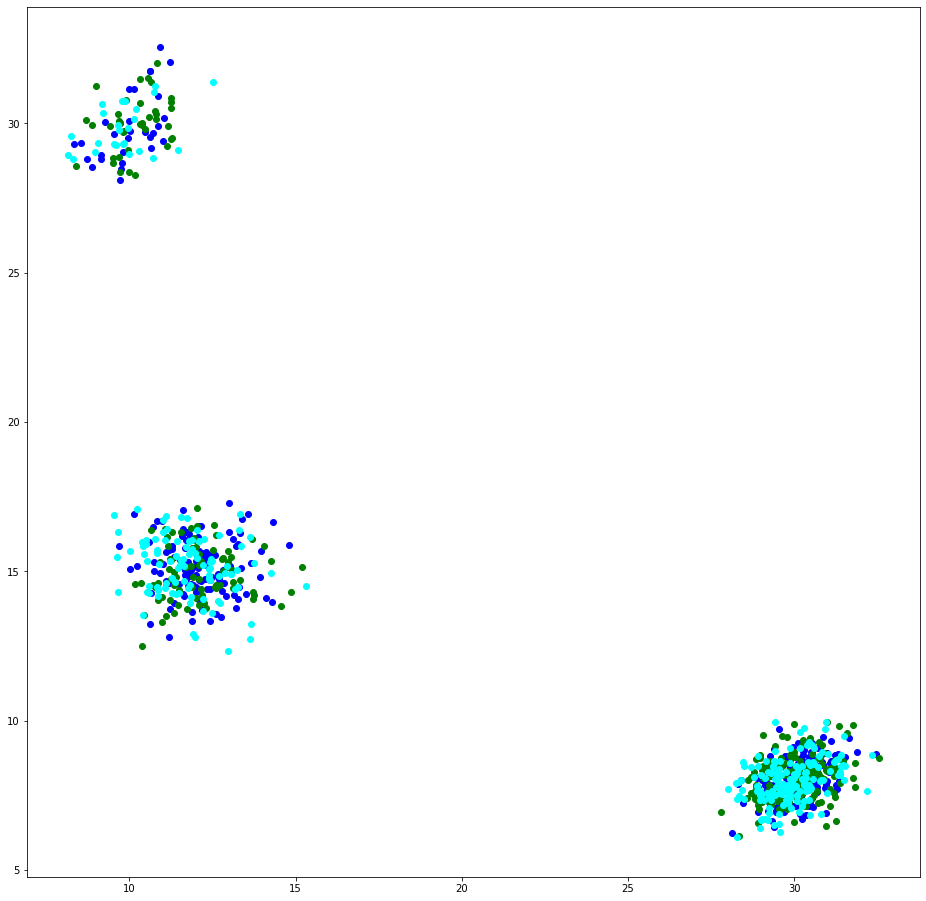

In [24]:
for k in range(num_cluster):
    ddata = frame[frame['random_label'] == k]
    plt.scatter(ddata['X'], ddata['Y'], c=color[k])

plt.show()

##### Visualisation after running gaussian mixture model 

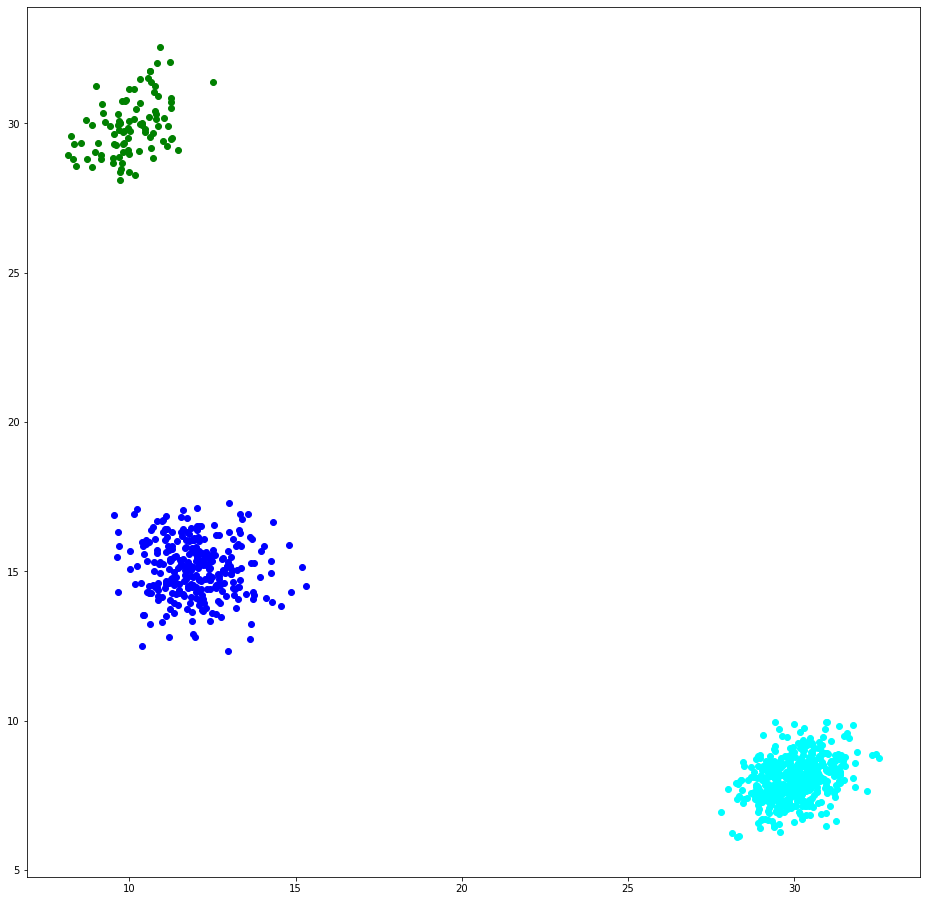

In [25]:
for k in range(num_cluster):
    ddata = frame[frame['model_label'] == k]
    plt.scatter(ddata['X'], ddata['Y'], c=color[k])

plt.show()

### Calculate mixture proportions 

In [26]:
model_params = []
for i, df in frame.groupby('model_label'):
    d = {}
    d['pi'] = len(df)/total_toss
    d['mu'] = (np.round(np.mean(df[["X"]].to_numpy().T),2), np.round(np.mean(frame[["Y"]].to_numpy().T),2))
    d['covariance'] = np.round(np.cov(df[["X", "Y"]].to_numpy().T), 2).tolist()
    model_params.append(d)

In [27]:
model_params

[{'pi': 0.32,
  'mu': (11.99, 12.55),
  'covariance': [[1.1, -0.08], [-0.08, 0.9]]},
 {'pi': 0.10333333333333333,
  'mu': (10.03, 12.55),
  'covariance': [[0.71, 0.35], [0.35, 0.93]]},
 {'pi': 0.5766666666666667,
  'mu': (30.02, 12.55),
  'covariance': [[0.63, 0.2], [0.2, 0.48]]}]

In [28]:
params

[{'pi': 0.1, 'mu': (10, 30), 'covariance': [[0.88, 0.5], [0.5, 0.99]]},
 {'pi': 0.6, 'mu': (30, 8), 'covariance': [[0.6, 0.2], [0.2, 0.5]]},
 {'pi': 0.3, 'mu': (12, 15), 'covariance': [[1, 0], [0, 1]]}]

### Compute maximum likelihood estimate 

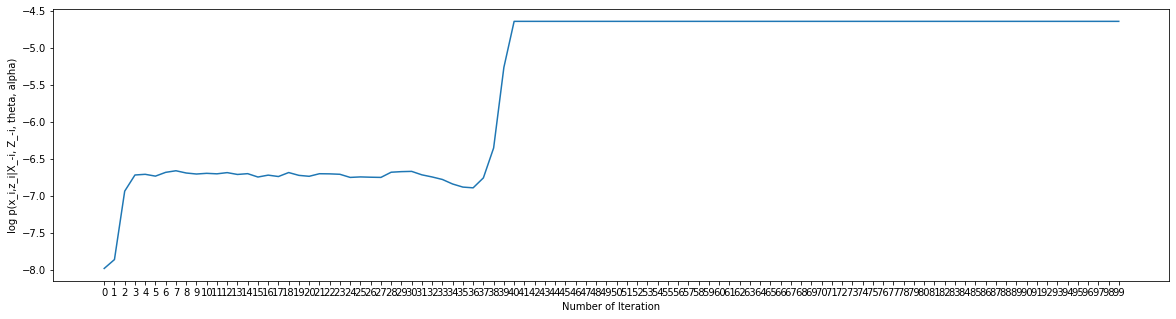

In [29]:
plt.figure(figsize=(20, 5))
plt.plot(total_performance)
plt.xlabel("Number of Iteration")
plt.ylabel("log p(x_i,z_i|X_-i, Z_-i, theta, alpha)")
plt.xticks([i for i in range(total_iter)])

plt.show()